# Chess.com Centrality Measures
This notebook contains Figure 4 (2-by-2 matrix of line charts) and Table 4 (Spearman's R correlations) from the paper. It also filters Chess.com match data to only include games between January 2, 2024 and October 1, 2024, with players who participated in at least 10 Titled Tuesday matches.

In [1]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import con_score

Filter Titled Tuesday Participants

In [2]:
df = pd.read_csv('../output/Chess.com/final_df.csv')
df['date'] = pd.to_datetime(df['date'], format="%B-%d-%Y")
stats = pd.read_csv("../output/Chess.com/player_stats.csv")

C:\Users\walaa\AppData\Local\Temp\ipykernel_14488\1053643370.py:1: DtypeWarning: Columns (2,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../output/Chess.com/final_df.csv')


In [3]:
min_games = 45
frequent_players = stats[stats.total_games > min_games].username.unique()
df = df[df.white_username.isin(frequent_players) & df.black_username.isin(frequent_players)]

In [4]:
df.to_csv('../output/Chess.com/final_df_min10.csv', index=False)

Create Digraph

In [5]:
G = nx.DiGraph()
for _, row in df.iterrows():
    white_player, black_player = row['white_username'], row['black_username']

    if row['white_result'] == '1': # white wins
        if G.has_edge(white_player, black_player):
            G[white_player][black_player]['weight'] += 1
        else:
            G.add_edge(white_player, black_player, weight=1)
    
    if row['black_result'] == '1': # black wins
        if G.has_edge(black_player, white_player):
            G[black_player][white_player]['weight'] += 1
        else:
            G.add_edge(black_player, white_player, weight=1)
    
    if row['white_result'] == '½': # draw 
        if G.has_edge(black_player, white_player):
            G[black_player][white_player]['weight'] += 0.5
        if G.has_edge(white_player, black_player):
            G[white_player][black_player]['weight'] += 0.5
        elif not G.has_edge(black_player, white_player):
            G.add_edge(black_player, white_player, weight=0.5)
        elif not G.has_edge(white_player, black_player):
            G.add_edge(white_player, black_player, weight=0.5)

In [6]:
G.number_of_nodes(), G.number_of_edges()

(2371, 178823)

Check sparsity of G

In [7]:
n = G.number_of_nodes()
m = G.number_of_edges()
sparsity = m / (n * (n - 1))
sparsity

0.03182317276087463

In [8]:
G_undirected = G.to_undirected()
nx.is_connected(G_undirected)

True

In [9]:
print(nx.number_weakly_connected_components(G))
print(nx.number_strongly_connected_components(G))

1
1


In [10]:
max_diameter = 0
for component in nx.weakly_connected_components(G):
    subgraph = G.subgraph(component)
    undirected_subgraph = subgraph.to_undirected()
    diameter = nx.diameter(undirected_subgraph)
    max_diameter = max(max_diameter, diameter)
print(f"Maximum Diameter of Weakly Connected Components (Undirected): {max_diameter}")

Maximum Diameter of Weakly Connected Components (Undirected): 3


In [11]:
df = df[df['white_elo'].notna()]
df = df[df['black_elo'].notna()]

df = df[df['white_elo']!='Unrated']
df = df[df['black_elo']!='Unrated']

df['white_elo'] = df['white_elo'].astype(int)
df['black_elo'] = df['black_elo'].astype(int)

#### Calculate CON and PageRank

In [12]:
try: 
    elo_dict = pd.read_pickle('../output/Chess.com/elo_dict.pkl')
except:
    elo_dict = {}
    for index, row in df.iterrows():
        elo_dict[row['white_username']] = row['white_elo']
    for index, row in df.iterrows():
        elo_dict[row['black_username']] = row['black_elo']
    with open('../output/Chess.com/elo_dict.pkl', 'wb') as f:
        pickle.dump(elo_dict, f)

In [13]:
try: 
    CON_score = pd.read_pickle('../output/Chess.com/CON_score_dict.pkl')
except:
    CON_score = con_score.compute_con_scores(G)
    with open('../output/Chess.com/CON_score_dict.pkl', 'wb') as f:
        pickle.dump(CON_score, f)

In [14]:
pagerank = nx.pagerank(G, weight='weight')

In [15]:
out_degree_centrality = dict(G.out_degree(weight='weight'))
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)

centrality_df = pd.DataFrame({
    'Player': list(G.nodes),
    'Out-Degree Centrality': [out_degree_centrality.get(player, 0) for player in G.nodes],
    'Closeness Centrality': [closeness_centrality.get(player, 0) for player in G.nodes],
    'Betweenness Centrality': [betweenness_centrality.get(player, 0) for player in G.nodes],
    'CON Score': [CON_score.get(player, 0) for player in G.nodes]
})

centrality_df['Elo'] = centrality_df['Player'].map(elo_dict).astype(float)

G_inverted = G.reverse(copy=True)
pagerank_centrality = nx.pagerank(G_inverted, weight='weight')
centrality_df['PageRank Centrality'] = [pagerank_centrality.get(player, 0) for player in centrality_df['Player']]

#### Unity Normalization of Rankings

In [16]:
for col in ['Out-Degree Centrality', 'Closeness Centrality', 'Betweenness Centrality', 'PageRank Centrality', 'CON Score', 'Elo']:
    centrality_df[col] = (centrality_df[col] - centrality_df[col].min()) / (centrality_df[col].max() - centrality_df[col].min())

In [17]:
centrality_df.Player.nunique()

2371

## Figure 4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


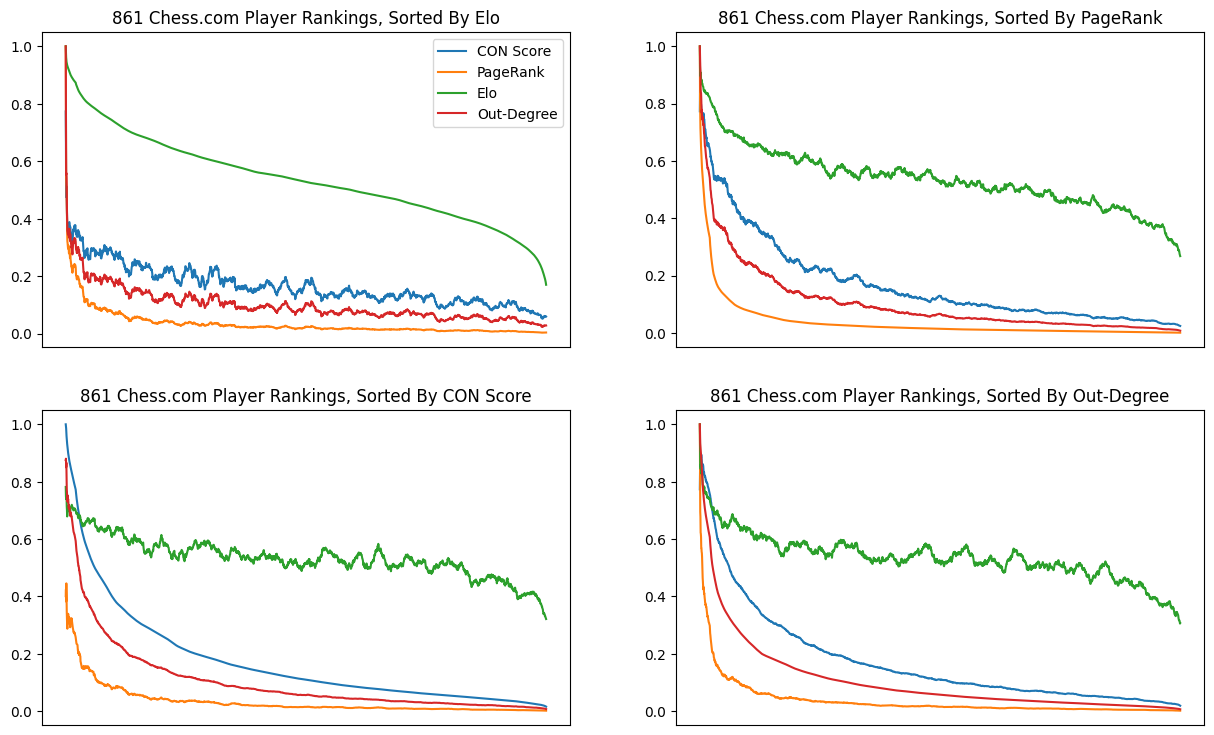

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(15, 9))
window_size = 50

def smooth_series(data, window):
    return data.rolling(window=window, min_periods=1).mean()

centrality_df_small = centrality_df.sort_values('Elo', ascending=False)
axs[0, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[0, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[0, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[0, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 0].set_title('861 Chess.com Player Rankings, Sorted By Elo')
axs[0, 0].legend()
axs[0, 0].set_xticks([])

centrality_df_small = centrality_df.sort_values('PageRank Centrality', ascending=False)
axs[0, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[0, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[0, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[0, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[0, 1].set_title('861 Chess.com Player Rankings, Sorted By PageRank')
axs[0, 1].set_xticks([])

centrality_df_small = centrality_df.sort_values('CON Score', ascending=False)
axs[1, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[1, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[1, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[1, 0].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 0].set_title('861 Chess.com Player Rankings, Sorted By CON Score')
axs[1, 0].set_xticks([])

centrality_df_small = centrality_df.sort_values('Out-Degree Centrality', ascending=False)
axs[1, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['CON Score'], window_size), label='CON Score')
axs[1, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['PageRank Centrality'], window_size), label='PageRank')
axs[1, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Elo'], window_size), label='Elo')
axs[1, 1].plot(centrality_df_small['Player'], smooth_series(centrality_df_small['Out-Degree Centrality'], window_size), label='Out-Degree')
axs[1, 1].set_title('861 Chess.com Player Rankings, Sorted By Out-Degree')
axs[1, 1].set_xticks([])

plt.savefig('../output/Chess.com/centrality_measures_MA_2x2_plot.eps', format='eps')
plt.show()

## Tabel 4: Spearman Correlations Table

In [19]:
spearman_out_degree = spearmanr(centrality_df['Elo'], centrality_df['Out-Degree Centrality'], nan_policy='omit')
spearman_closeness = spearmanr(centrality_df['Elo'], centrality_df['Closeness Centrality'], nan_policy='omit')
spearman_betweenness = spearmanr(centrality_df['Elo'], centrality_df['Betweenness Centrality'], nan_policy='omit')
spearman_pagerank = spearmanr(centrality_df['Elo'], centrality_df['PageRank Centrality'], nan_policy='omit')
spearman_conscore = spearmanr(centrality_df['Elo'], centrality_df['CON Score'], nan_policy='omit')

results = {
    'Centrality Metric': [
        'Out-Degree Centrality',
        'Closeness Centrality',
        'Betweenness Centrality',
        'PageRank Centrality',
        'CON Score'
    ],
    'Spearmans R Statistic': [
        spearman_out_degree.correlation,
        spearman_closeness.correlation,
        spearman_betweenness.correlation,
        spearman_pagerank.correlation,
        spearman_conscore.correlation
    ],
    'P-Value': [
        spearman_out_degree.pvalue,
        spearman_closeness.pvalue,
        spearman_betweenness.pvalue,
        spearman_pagerank.pvalue,
        spearman_conscore.pvalue
    ]
}

spearman_df = pd.DataFrame(results)
spearman_df.sort_values('Spearmans R Statistic', ascending=False)

,Centrality Metric,Spearmans R Statistic,P-Value
3,PageRank Centrality,0.664114,1.439402e-301
0,Out-Degree Centrality,0.464441,3.610871e-127
4,CON Score,0.411284,1.867134e-97
2,Betweenness Centrality,0.228198,2.199129e-29
1,Closeness Centrality,-0.359152,4.126508e-73


In [20]:
spearman_df.to_csv('../output/Chess.com/Chess_spearman_correlations_table.csv', index=False)